In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os

In [12]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [13]:
image = cv2.imread('../../data/outputs/bagids/0344100000005805/0344100000005805.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

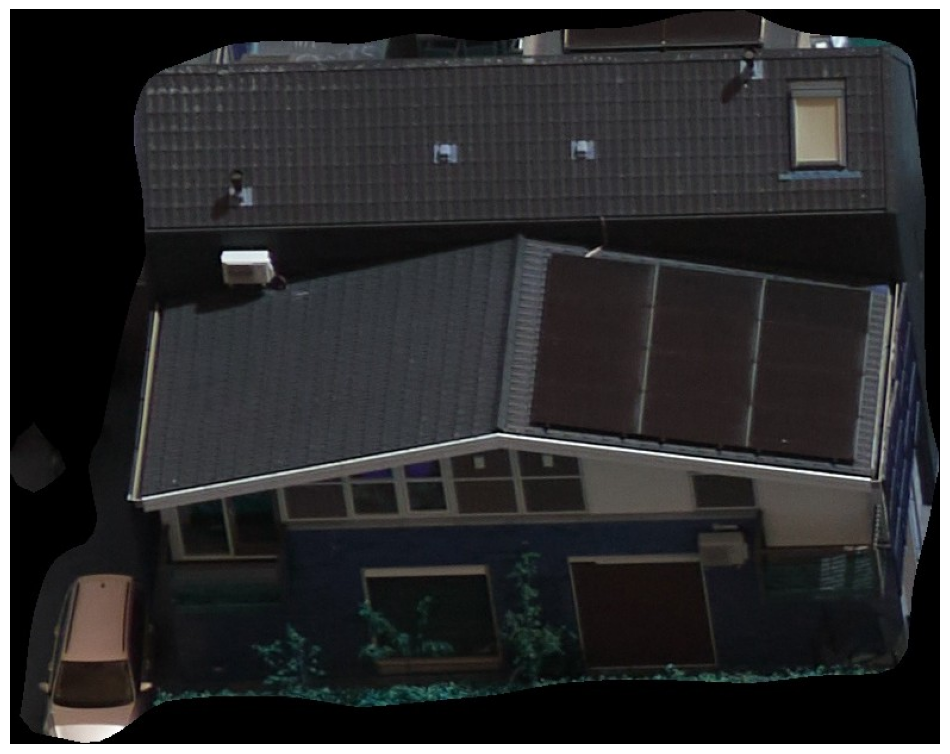

In [14]:
plt.figure(figsize=(12,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [16]:
# Loading the SAM model and predictor
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# vit_h model checkpoint
#sam_checkpoint = "../../experiments/checkpoints/sam_vit_h_4b8939.pth"
#model_type = "vit_h"

# vit_b model checkpoint
sam_checkpoint = "../../experiments/checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [17]:
masks = mask_generator.generate(image)

In [18]:
print(len(masks))
print(masks[0].keys())

49
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Saved mask 1 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_1.jpg
Saved mask 2 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_2.jpg
Saved mask 3 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_3.jpg
Saved mask 4 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_4.jpg
Saved mask 5 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_5.jpg
Saved mask 6 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_6.jpg
Saved mask 7 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_7.jpg
Saved mask 8 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_8.jpg
Saved mask 9 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_9.jpg
Saved mask 10 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_10.jpg
Saved mask 11 to ../../data/outputs/bagids/0344100000005805/buildinglevelmasks/mask_11.jpg
Saved mask 12 to 

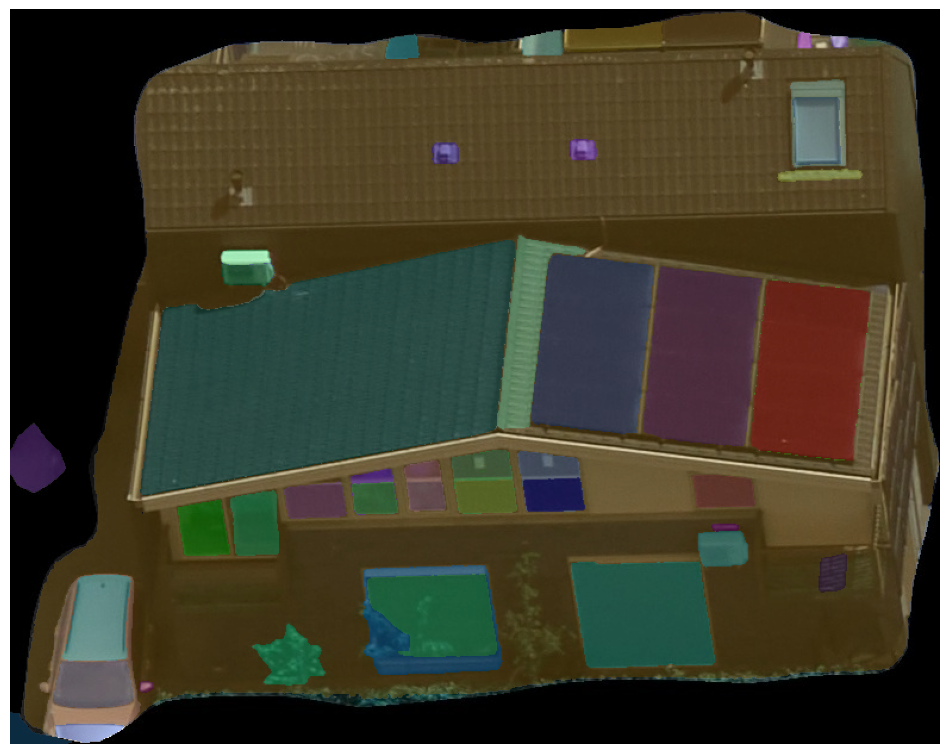

In [20]:
# Create a directory to store the masks
output_dir = '../../data/outputs/bagids/0344100000005805/buildinglevelmasks/'
os.makedirs(output_dir, exist_ok=True)

for i, mask in enumerate(masks):
    # Extract the segmentation mask
    mask_image = mask['segmentation']  # This is a binary mask

    # Create a 3-channel image to hold the original pixel values inside the mask
    masked_image = np.zeros_like(image)  # Create an empty image of the same size as the original image

    # Set the pixels in the masked_image where the mask is 1 to the corresponding pixels in the original image
    masked_image[mask_image == 1] = image[mask_image == 1]

    # Define the output file path for each mask
    mask_output_path = os.path.join(output_dir, f"mask_{i+1}.jpg")

    # Save the masked image containing original pixel values inside the mask
    cv2.imwrite(mask_output_path, cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving as JPG

    print(f"Saved mask {i+1} to {mask_output_path}")

# Optionally, display all masks on the image
plt.figure(figsize=(12,10))
plt.imshow(image)
show_anns(masks)  # Display all the masks
plt.axis('off')
plt.show()